In [1]:
using LinearAlgebra
using Plots
import JSON
# using Quaternions
using StaticArrays, Rotations
using Distributed
using StaticArrays, BenchmarkTools
using Base.Threads
using CUDAnative
using CuArrays,CUDAdrv 
using Test
import Base: +, * , -, ^


┌ Info: Recompiling stale cache file C:\Users\amira\.julia\compiled\v1.2\CUDAnative\4Zu2W.ji for CUDAnative [be33ccc6-a3ff-5ff2-a52e-74243cff1e17]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file C:\Users\amira\.julia\compiled\v1.2\CuArrays\7YFE0.ji for CuArrays [3a865a2d-5b23-5a0f-bc46-62713ec82fae]
└ @ Base loading.jl:1240


In [3]:
struct Vector3
    x::Float32
    y::Float32
    z::Float32
    function Vector3()
        x=0.0
        y=0.0
        z=0.0
        new(x,y,z)
    end
    function Vector3(x,y,z)
       new(x,y,z)
    end
end
struct Quaternion
    x::Float32
    y::Float32
    z::Float32
    w::Float32
    function Quaternion()
        x=0.0
        y=0.0
        z=0.0
        w=1.0
        new(x,y,z,w)
    end
    function Quaternion(x,y,z,w)
        new(x,y,z,w)
    end
end
struct RotationMatrix
    te1::Float32
    te2::Float32
    te3::Float32
    te4::Float32
    te5::Float32
    te6::Float32
    te7::Float32
    te8::Float32
    te9::Float32
    te10::Float32
    te11::Float32
    te12::Float32
    te13::Float32
    te14::Float32
    te15::Float32
    te16::Float32
    function RotationMatrix()
        te1 =0.0
        te2 =0.0
        te3 =0.0
        te4 =0.0
        te5 =0.0
        te6 =0.0
        te7 =0.0
        te8 =0.0
        te9 =0.0
        te10=0.0
        te11=0.0
        te12=0.0
        te13=0.0
        te14=0.0
        te15=0.0
        te16=0.0
        new(te1,te2,te3,te4,te5,te6,te7,te8,te9,te10,te11,te12,te13,te14,te15,te16)
    end
    function RotationMatrix(te1,te2,te3,te4,te5,te6,te7,te8,te9,te10,te11,te12,te13,te14,te15,te16)
        new(te1,te2,te3,te4,te5,te6,te7,te8,te9,te10,te11,te12,te13,te14,te15,te16)
    end
end

+(f::Vector3, g::Vector3)=Vector3(f.x+g.x , f.y+g.y,f.z+g.z )
-(f::Vector3, g::Vector3)=Vector3(f.x-g.x , f.y-g.y,f.z-g.z )
*(f::Vector3, g::Vector3)=Vector3(f.x*g.x , f.y*g.y,f.z*g.z )

+(f::Vector3, g::Number)=Vector3(f.x+g , f.y+g,f.z+g )
-(f::Vector3, g::Number)=Vector3(f.x-g , f.y-g,f.z-g )
*(f::Vector3, g::Number)=Vector3(f.x*g , f.y*g,f.z*g )

+(g::Vector3, f::Number)=Vector3(f.x+g , f.y+g,f.z+g )
-(g::Vector3, f::Number)=Vector3(g-f.x , g-f.y,g-f.z )
*(g::Vector3, f::Number)=Vector3(f.x*g , f.y*g,f.z*g )

addX(f::Vector3, g::Number)=Vector3(f.x+g , f.y,f.z)
addY(f::Vector3, g::Number)=Vector3(f.x , f.y+g,f.z )
addZ(f::Vector3, g::Number)=Vector3(f.x , f.y,f.z+g )

function normalizeVector3(f::Vector3)
    leng=sqrt((f.x * f.x) + (f.y * f.y) + (f.z * f.z))
    return Vector3(f.x/leng,f.y/leng,f.z/leng)
    
end


function normalizeQuaternion(f::Quaternion)
    l = sqrt((f.x * f.x) + (f.y * f.y) + (f.z * f.z)+ (f.w * f.w))
    if l === 0 
        qx = 0
        qy = 0
        qz = 0
        qw = 1
    else 
        l = 1 / l
        qx = f.x * l
        qy = f.y * l
        qz = f.z * l
        qw = f.w * l
    end
    return Quaternion(qx,qy,qz,qw)
end

function normalizeQuaternion1!(fx::Float32,fy::Float32,fz::Float32,fw::Float32)
    l = sqrt((fx * fx) + (fy * fy) + (fz * fz)+ (fw * fw))
    if l === 0 
        qx = 0.0
        qy = 0.0
        qz = 0.0
        qw = 1.0
    else 
        l = 1.0 / l
        qx = fx * l
        qy = fy * l
        qz = fz * l
        qw = fw * l
    end
    return qx,qy,qz,qw
end


function dotVector3(f::Vector3, g::Vector3)
    return (f.x * g.x) + (f.y * g.y) + (f.z * g.z)
end

function Base.show(io::IO, v::Vector3)
    print(io, "x:$(v.x), y:$(v.y), z:$(v.z)")
end

function Base.show(io::IO, v::Quaternion)
    print(io, "x:$(v.x), y:$(v.y), z:$(v.z), w:$(v.z)")
end

Base.Broadcast.broadcastable(q::Vector3) = Ref(q)

In [4]:
mutable struct Node
    id::Int32
    position::Vector3
    restrained::Bool
    displacement::Vector3
    angle::Vector3
    force::Vector3
    currPosition::Vector3
    orient::Quaternion
    linMom::Vector3
    angMom::Vector3
    intForce::Vector3
    intMoment::Vector3
    moment::Vector3
    function Node()
        id=0
        position=Vector3()
        restrained=false
        displacement=Vector3()
        angle=Vector3()
        force=Vector3()
        currPosition=Vector3()
        orient=Quaternion()
        linMom=Vector3()
        angMom=Vector3()
        intForce=Vector3()
        intMoment=Vector3()
        moment=Vector3()
        new(id,position,restrained,displacement,angle,force,currPosition,orient,linMom,angMom,intForce,intMoment,moment)
    end
end


mutable struct Edge
    id::Int32
    source::Int32 #change to Int32
    target::Int32
    area::Float32
    density::Float32
    stiffness::Float32
    stress::Float32
    axis::Vector3
    currentRestLength::Float32
    pos2::Vector3
    angle1v::Vector3
    angle2v::Vector3
    angle1::Quaternion
    angle2::Quaternion
    currentTransverseStrainSum::Float32
    ## add pos node and negative node
    ## add memory cuda??
    function Edge()
        id=0
        source=0
        target=0
        area=0.0
        density=0.0
        stiffness=0.0
        stress=0.0
        axis=Vector3(1.0,0.0,0.0)
        currentRestLength=0.0
        pos2=Vector3()
        angle1v=Vector3()
        angle2v=Vector3()
        angle1=Quaternion()
        angle2=Quaternion()
        currentTransverseStrainSum=0.0
        
        new(id,source,target,area,density,stiffness,stress,axis,currentRestLength,pos2,angle1v,angle2v,angle1,angle2,currentTransverseStrainSum)
    end
end

function Base.show(io::IO, v::Node)
    print(io, "node:$(v.id), position:($(v.position)), restrained:$(v.restrained)")
end

function Base.show(io::IO, v::Edge)
    print(io, "edge:$(v.id), source:$(v.source), target:$(v.target), stress:$(v.stress), axis:($(v.axis))")
end



In [5]:
# allowscalar(false)
m=Vector3(1.0,1.0,1.0)
mg=CuArray([m,m,m])
mm=mg.+m
# broadcast(+, mg, m)
# broadcast(addX, mg, 1)

# m=node
# println(m)
# m=Node()
# mg=CuArray([m,m,m])

┌ Info: Building the CUDAnative run-time library for your sm_61 device, this might take a while...
└ @ CUDAnative C:\Users\amira\.julia\packages\CUDAnative\Phjco\src\compiler\rtlib.jl:188


3-element CuArray{Vector3,1,Nothing}:
 x:2.0, y:2.0, z:2.0
 x:2.0, y:2.0, z:2.0
 x:2.0, y:2.0, z:2.0

In [6]:
mat=RotationMatrix()

RotationMatrix(0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0)

In [7]:
###############################################################################################
setup = Dict()
open("../json/setupValid2.json", "r") do f
    global setup
    dicttxt = String(read(f))  # file information to string
    setup=JSON.parse(dicttxt)  # parse and transform data
end

setup=setup["setup"]

Dict{String,Any} with 6 entries:
  "nodes"     => Any[Dict{String,Any}("degrees_of_freedom"=>Any[0, 1, 2, 3, 4, …
  "bar"       => false
  "animation" => Dict{String,Any}("speed"=>3,"exaggeration"=>100,"showDisplaceme…
  "viz"       => Dict{String,Any}("colorMap"=>0,"colorMaps"=>Any[],"maxStress"=…
  "edges"     => Any[Dict{String,Any}("currentRestLength"=>0,"source"=>0,"area"…
  "ndofs"     => 18

In [8]:
function initialize(setup)
	nodes      = setup["nodes"]
    edges      = setup["edges"]
    
    i=1
	# pre-calculate current position
	for node in nodes
        # element=parse(Int,node["id"][2:end])
        N_position[i]=Vector3(node["position"]["x"],node["position"]["y"],node["position"]["z"])
        N_restrained[i]=node["restrained_degrees_of_freedom"][1] ## todo later consider other degrees of freedom
        N_displacement[i]=Vector3(node["displacement"]["x"],node["displacement"]["y"],node["displacement"]["z"])
        N_angle[i]=Vector3(node["angle"]["x"],node["angle"]["y"],node["angle"]["z"])
        N_force[i]=Vector3(node["force"]["x"],node["force"]["y"],node["force"]["z"])
        N_currPosition[i]=Vector3(node["position"]["x"],node["position"]["y"],node["position"]["z"])

        # for dynamic simulations
        # append!(N_posTimeSteps,[[]])
        # append!(N_angTimeSteps,[[]])
        
        i=i+1
	end 
    
    i=1
	# pre-calculate the axis
	for edge in edges
        # element=parse(Int,edge["id"][2:end])
        
        # find the nodes that the lements connects
        fromNode = nodes[edge["source"]+1]
        toNode = nodes[edge["target"]+1]

        
        node1 = [fromNode["position"]["x"] fromNode["position"]["y"] fromNode["position"]["z"]]
        node2 = [toNode["position"]["x"] toNode["position"]["y"] toNode["position"]["z"]]
        
        length=norm(node2-node1)
        axis=normalize(collect(Iterators.flatten(node2-node1)))
        
        E_source[i]=edge["source"]+1
        E_target[i]=edge["target"]+1
        E_area[i]=edge["area"]
        E_density[i]=edge["density"]
        E_stiffness[i]=edge["stiffness"]
        E_axis[i]=Vector3(axis[1],axis[2],axis[3])
        E_currentRestLength[i]=length
        
        N_edgeID[E_source[i],N_currEdge[E_source[i]]]=i
        N_edgeFirst[E_source[i],N_currEdge[E_source[i]]]=true
        N_currEdge[E_source[i]]+=1
        
        N_edgeID[E_target[i],N_currEdge[E_target[i]]]=i
        N_edgeFirst[E_target[i],N_currEdge[E_target[i]]]=false
        N_currEdge[E_target[i]]+=1
       
        
        # for dynamic simulations
        # append!(E_stressTimeSteps,[[]])
        
        i=i+1
	end 
end

initialize (generic function with 1 method)

In [36]:
########
voxCount=0
linkCount=0
nodes      = setup["nodes"]
edges      = setup["edges"]
voxCount=size(nodes)[1]
linkCount=size(edges)[1]
strain =0 #todooo moveeee
maxNumEdges=10


# Nodes=fill(Node(),voxCount)
# Edges=fill(Edge(),linkCount)

########
voxCount=0
linkCount=0
nodes      = setup["nodes"]
edges      = setup["edges"]
voxCount=size(nodes)[1]
linkCount=size(edges)[1]
strain =0 #todooo moveeee

############# nodes
N_position=fill(Vector3(),voxCount)
N_restrained=zeros(Bool, voxCount)
N_displacement=fill(Vector3(),voxCount)
N_angle=fill(Vector3(),voxCount)
N_currPosition=fill(Vector3(),voxCount)
N_linMom=fill(Vector3(),voxCount)
N_angMom=fill(Vector3(),voxCount)
N_intForce=fill(Vector3(),voxCount)
N_intMoment=fill(Vector3(),voxCount)
N_moment=fill(Vector3(),voxCount)
# N_posTimeSteps=[]
# N_angTimeSteps=[]
N_force=fill(Vector3(),voxCount)
N_orient=fill(Quaternion(),voxCount)
N_edgeID=fill(-1,(voxCount,maxNumEdges))
N_edgeFirst=fill(true,(voxCount,maxNumEdges))
N_currEdge=fill(1,voxCount)

############# edges
E_source=fill(0,linkCount)
E_target=fill(0,linkCount)
E_area=fill(0.0f0,linkCount)
E_density=fill(0.0f0,linkCount)
E_stiffness=fill(0.0f0,linkCount)
E_stress=fill(0.0f0,linkCount)
E_axis=fill(Vector3(1.0,0.0,0.0),linkCount)
E_currentRestLength=fill(0.0f0,linkCount)
E_pos2=fill(Vector3(),linkCount)
E_angle1v=fill(Vector3(),linkCount)
E_angle2v=fill(Vector3(),linkCount)
E_angle1=fill(Quaternion(),linkCount)
E_angle2=fill(Quaternion(),linkCount)

E_intForce1=fill(Vector3(),linkCount)
E_intMoment1=fill(Vector3(),linkCount) 

E_intForce2=fill(Vector3(),linkCount)
E_intMoment2=fill(Vector3(),linkCount) 

E_currentTransverseStrainSum=fill(0.0f0,linkCount)# TODO remove ot incorporate
# E_stressTimeSteps=[]


#################################################################
initialize(setup)
#################################################################

########################## turn to cuda arrays
############# nodes
N_positionGPU=    CuArray(N_position)  
N_restrainedGPU=  CuArray(N_restrained)  
N_displacementGPU=CuArray(N_displacement)   
N_angleGPU=       CuArray(N_angle)  
N_currPositionGPU=CuArray(N_currPosition)    
N_linMomGPU=      CuArray(N_linMom)    
N_angMomGPU=      CuArray(N_angMom)  
N_intForceGPU=    CuArray(N_intForce) 
N_intMomentGPU=   CuArray(N_intMoment)   
N_momentGPU=      CuArray(N_moment)
N_forceGPU=       CuArray(N_force)  
N_orientGPU=      CuArray(N_orient)
N_edgeIDGPU=      CuArray(N_edgeID)
N_edgeFirstGPU=   CuArray(N_edgeFirst)
 

############# edges
E_sourceGPU=                    CuArray(E_source)   
E_targetGPU=                    CuArray(E_target)
E_areaGPU=                      CuArray(E_area)                             
E_densityGPU=                   CuArray(E_density)
E_stiffnessGPU=                 CuArray(E_stiffness)
E_stressGPU=                    CuArray(E_stress)
E_axisGPU=                      CuArray(E_axis)          
E_currentRestLengthGPU=         CuArray(E_currentRestLength)
E_pos2GPU=                      CuArray(E_pos2)
E_angle1vGPU=                   CuArray(E_angle1v)
E_angle2vGPU=                   CuArray(E_angle2v)
E_angle1GPU=                    CuArray(E_angle1)
E_angle2GPU=                    CuArray(E_angle2)
E_currentTransverseStrainSumGPU=CuArray(E_currentTransverseStrainSum)
E_intForce1GPU=      CuArray(E_intForce1) 
E_intMoment1GPU=     CuArray(E_intMoment1)  
E_intForce2GPU=      CuArray(E_intForce2) 
E_intMoment2GPU=     CuArray(E_intMoment2) 
# E_stressTimeSteps=[]

dt=0.0251646
numTimeSteps=100
@timed simulateParallel(numTimeSteps,dt)

┌ Warning: calls to Base intrinsics might be GPU incompatible
│   exception = (CUDAnative.MethodSubstitutionWarning(asin(x::T) where T<:Union{Float32, Float64} in Base.Math at special/trig.jl:435, asin(x::Float32) in CUDAnative at C:\Users\amira\.julia\packages\CUDAnative\Phjco\src\device\cuda\math.jl:30), Base.StackTraces.StackFrame[asin at trig.jl:435, setFromRotationMatrix at In[24]:13, toAxisXVector3 at In[18]:3, orientLink! at In[17]:4, updateEdges! at In[15]:4])
└ @ CUDAnative C:\Users\amira\.julia\packages\CUDAnative\Phjco\src\compiler\irgen.jl:116
┌ Warning: calls to Base intrinsics might be GPU incompatible
│   exception = (CUDAnative.MethodSubstitutionWarning(atan(x::T) where T<:Union{Float32, Float64} in Base.Math at special/trig.jl:519, atan(x::Float32) in CUDAnative at C:\Users\amira\.julia\packages\CUDAnative\Phjco\src\device\cuda\math.jl:33), Base.StackTraces.StackFrame[atan at trig.jl:519, atan at trig.jl:586, setFromRotationMatrix at In[24]:13, toAxisXVector3 at In[18]

┌ Warning: calls to Base intrinsics might be GPU incompatible
│   exception = (CUDAnative.MethodSubstitutionWarning(atan(x::T) where T<:Union{Float32, Float64} in Base.Math at special/trig.jl:519, atan(x::Float32) in CUDAnative at C:\Users\amira\.julia\packages\CUDAnative\Phjco\src\device\cuda\math.jl:33), Base.StackTraces.StackFrame[atan at trig.jl:519, atan at trig.jl:586, setFromRotationMatrix at In[24]:13, toAxisXQuat at In[20]:3, orientLink! at In[17]:4, updateEdges! at In[15]:4])
└ @ CUDAnative C:\Users\amira\.julia\packages\CUDAnative\Phjco\src\compiler\irgen.jl:116
┌ Warning: calls to Base intrinsics might be GPU incompatible
│   exception = (CUDAnative.MethodSubstitutionWarning(atan(x::T) where T<:Union{Float32, Float64} in Base.Math at special/trig.jl:519, atan(x::Float32) in CUDAnative at C:\Users\amira\.julia\packages\CUDAnative\Phjco\src\device\cuda\math.jl:33), Base.StackTraces.StackFrame[atan at trig.jl:519, atan at trig.jl:586, setFromRotationMatrix at In[24]:13, toAxis

┌ Warning: calls to Base intrinsics might be GPU incompatible
│   exception = (CUDAnative.MethodSubstitutionWarning(atan(x::T) where T<:Union{Float32, Float64} in Base.Math at special/trig.jl:519, atan(x::Float32) in CUDAnative at C:\Users\amira\.julia\packages\CUDAnative\Phjco\src\device\cuda\math.jl:33), Base.StackTraces.StackFrame[atan at trig.jl:519, atan at trig.jl:586, setFromRotationMatrix at In[24]:13, toAxisOriginalQuat at In[21]:2, updateEdges! at In[15]:4])
└ @ CUDAnative C:\Users\amira\.julia\packages\CUDAnative\Phjco\src\compiler\irgen.jl:116
┌ Warning: calls to Base intrinsics might be GPU incompatible
│   exception = (CUDAnative.MethodSubstitutionWarning(atan(x::T) where T<:Union{Float32, Float64} in Base.Math at special/trig.jl:519, atan(x::Float32) in CUDAnative at C:\Users\amira\.julia\packages\CUDAnative\Phjco\src\device\cuda\math.jl:33), Base.StackTraces.StackFrame[atan at trig.jl:519, atan at trig.jl:586, setFromRotationMatrix at In[24]:13, toAxisOriginalQuat at In

CUDAnative.InvalidIRError: InvalidIRError: compiling updateNodes!(Float64, Int64, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}, CuDeviceArray{Bool,1,CUDAnative.AS.Global}, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}, CuDeviceArray{Quaternion,1,CUDAnative.AS.Global}, CuDeviceArray{Int64,2,CUDAnative.AS.Global}, CuDeviceArray{Bool,2,CUDAnative.AS.Global}, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}, CuDeviceArray{Vector3,1,CUDAnative.AS.Global}) resulted in invalid LLVM IR
Reason: unsupported dynamic function invocation (call to force)
Stacktrace:
 [1] updateNodes! at In[16]:20

In [10]:
N,M=size(N_edgeIDGPU)
println("voxCount $voxCount linkCount $linkCount")

voxCount 8 linkCount 12


In [11]:
function simulateParallel(numTimeSteps,dt,static=true)
#     initialize(setup)
    
    for i in 1:numTimeSteps
#         println("Timestep:",i)
        doTimeStep(dt,static,i)
    end
end


UndefVarError: UndefVarError: doTimeStep not defined

In [12]:
function updateDataAndSave(setup,fileName)
    nodes      = setup["nodes"]
    edges      = setup["edges"]
    
    setup["animation"]["showDisplacement"]=false
    voxCount=size(nodes)[1]
    linkCount=size(edges)[1]
    
    N_displacement=Array(N_displacementGPU)
    N_angle=Array(N_angleGPU)
    E_stress=Array(E_stressGPU)
    
    setup["viz"]["maxStress"]=maximum(E_stress)
    setup["viz"]["minStress"]=minimum(E_stress)  

    i=1
	for edge in edges
        edge["stress"]=E_stress[i]
        i=i+1

    end
    
 
    i=1          
	for node in nodes
        node["displacement"]["x"]=N_displacement[i].x
        node["displacement"]["y"]=N_displacement[i].y
        node["displacement"]["z"]=N_displacement[i].z
        
        node["angle"]["x"]=N_angle[i].x
        node["angle"]["y"]=N_angle[i].y
        node["angle"]["z"]=N_angle[i].z
        i=i+1

    end
    
    # pass data as a json string (how it shall be displayed in a file)
    stringdata = JSON.json(setup)

    # write the file with the stringdata variable information
    open(fileName, "w") do f
            write(f, stringdata)
         end
    
end
updateDataAndSave(setup,"../json/trialJuliaParallelGPU.json")

4608

In [13]:
function addScalar(vec,sc)
    return vec+Vector3(sc,sc,sc)
end

function updateEdges1!(E_source, E_target, E_stress,E_intForce1,E_intForce2,N_intForce)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = blockDim().x * gridDim().x
    ## @cuprintln("thread $index, block $stride")
    for i = index:stride:length(E_source)
        @inbounds E_stress[i]=10.0
#         @inbounds s=E_source[i]
#         @inbounds t=E_target[i]
        #N_intForce[s]=N_intForce[s]+Vector3(0.1,0.1,0.1)
        #N_intForce[t]=N_intForce[t]+Vector3(0.1,0.1,0.1)
        @inbounds E_intForce1[i]=Vector3(0.1,0.1,0.1)
        @inbounds E_intForce2[i]=Vector3(0.1,0.1,0.1)
        #@inbounds  N_positionVGPU[i]=ifelse(N_restrainedGPU[i], N_positionVGPU[i], N_positionVGPU[i] +vecGPU[i] )
    end
    return
end


function bench_updateEdges!(E_source, E_target, E_stress,E_intForce1,E_intForce2,N_intForce)
    N=length(E_source)
    numblocks = ceil(Int, N/256)
    CuArrays.@sync begin
        @cuda threads=256 blocks=numblocks updateEdges1!(E_source, E_target, E_stress,E_intForce1,E_intForce2,N_intForce)
    end
end
# @btime bench_updateEdges!(E_sourceGPU, E_targetGPU, E_stressGPU,E_intForce1GPU,E_intForce2GPU,N_intForceGPU)
# @timed bench_updateEdges!(E_sourceGPU, E_targetGPU, E_stressGPU,E_intForce1GPU,E_intForce2GPU,N_intForceGPU)

bench_updateEdges! (generic function with 1 method)

In [14]:
function doTimeStep(dt,static,currentTimeStep)
    # update forces: go through edges, get currentposition from nodes, calc pos2 and update stresses and interior forces of nodes
    run_updateEdges!(
        E_sourceGPU, 
        E_targetGPU,
        E_areaGPU,
        E_densityGPU,
        E_stiffnessGPU,
        E_stressGPU,
        E_axisGPU,
        E_currentRestLengthGPU,
        E_pos2GPU,
        E_angle1vGPU,
        E_angle2vGPU,
        E_angle1GPU,
        E_angle2GPU,
        E_intForce1GPU,
        E_intMoment1GPU,
        E_intForce2GPU,
        E_intMoment2GPU,
        N_currPositionGPU,
        N_orientGPU)
    
    # update forces: go through nodes and update interior force (according to int forces from edges), integrate and update currpos
    run_updateNodes!(dt,currentTimeStep,
        N_positionGPU, 
        N_restrainedGPU,
        N_displacementGPU,
        N_angleGPU,
        N_currPositionGPU,
        N_linMomGPU,
        N_angMomGPU,
        N_intForceGPU,
        N_intMomentGPU,
        N_forceGPU,
        N_momentGPU,
        N_orientGPU,
        N_edgeIDGPU, 
        N_edgeFirstGPU, 
        E_intForce1GPU,
        E_intMoment1GPU,
        E_intForce2GPU,
        E_intMoment2GPU)
    
end

doTimeStep (generic function with 1 method)

In [15]:
function updateEdges!(E_source,E_target,E_area,E_density,E_stiffness,E_stress,E_axis,E_currentRestLength,
        E_pos2,E_angle1v,E_angle2v,E_angle1,E_angle2,E_intForce1,E_intMoment1,E_intForce2,E_intMoment2,N_currPosition,N_orient)
    
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = blockDim().x * gridDim().x
    ## @cuprintln("thread $index, block $stride")
    N=length(E_source)
    for i = index:stride:N
        
        @inbounds pVNeg=N_currPosition[E_source[i]]
        @inbounds pVPos=N_currPosition[E_target[i]]
        
        @inbounds oVNeg=N_orient[E_source[i]]
        @inbounds oVPos=N_orient[E_target[i]]
        
        @inbounds oldPos2=E_pos2[i] #?copy?
        @inbounds oldAngle1v = E_angle1v[i]
        @inbounds oldAngle2v =  E_angle2v[i]# remember the positions/angles from last timestep to calculate velocity
        
#         E_pos2[i],E_angle1v[i],E_angle2v[i],E_angle1[i],E_angle2[i],
        @inbounds E_pos2[i],E_angle1v[i],E_angle2v[i],E_angle1[i],E_angle2[i],totalRot= orientLink!(E_currentRestLength[i],pVNeg,pVPos,oVNeg,oVPos,E_axis[i])
        @inbounds m=(E_pos2[i].x/E_currentRestLength[i])
        @inbounds _stress=updateStrain(m,E_stiffness[i])
        @inbounds E_stress[i]=_stress
#         @cuprintln(_stress)
        
        @inbounds l   = E_currentRestLength[i]
        @inbounds E = E_stiffness[i]
        
        nu=0
        L = 5.0
        a1 = E*L # EA/L : Units of N/m
        a2 = E * L*L*L / (12.0*(1+nu)) # GJ/L : Units of N-m
        b1 = E*L # 12EI/L^3 : Units of N/m
        b2 = E*L*L/2.0 # 6EI/L^2 : Units of N (or N-m/m: torque related to linear distance)
        b3 = E*L*L*L/6.0 # 2EI/L : Units of N-m
        @inbounds currentTransverseArea=E_area[i]
        
        x=(_stress*currentTransverseArea)
        @inbounds y=(b1*E_pos2[i].y-b2*(E_angle1v[i].z + E_angle2v[i].z))
        @inbounds z=(b1*E_pos2[i].z + b2*(E_angle1v[i].y + E_angle2v[i].y))
        x=convert(Float32,x)
        y=convert(Float32,y)
        z=convert(Float32,z)
        
        # Use Curstress instead of -a1*Pos2.x to account for non-linear deformation 
        forceNeg = Vector3(x,y,z)
        # forceNeg = Vector3((_stress*currentTransverseArea),(b1*E_pos2[edge].y-b2*(E_angle1v[i].z + E_angle2v[i].z)),(b1*E_pos2[i].z + b2*(E_angle1v[i].y + E_angle2v[i].y))) # Use Curstress instead of -a1*Pos2.x to account for non-linear deformation 
        forcePos = Vector3(-x,-y,-z)
        
        @inbounds x= (a2*(E_angle2v[i].x-E_angle1v[i].x))
        @inbounds y= (-b2*E_pos2[i].z-b3*(2.0*E_angle1v[i].y+E_angle2v[i].y))
        @inbounds z=(b2*E_pos2[i].y - b3*(2.0*E_angle1v[i].z + E_angle2v[i].z))  
        x=convert(Float32,x)
        y=convert(Float32,y)
        z=convert(Float32,z)
        momentNeg = Vector3(x,y,z)
        # momentNeg = Vector3((a2*(E_angle2v[i].x-E_angle1v[i].x)) , (-b2*E_pos2[i].z-b3*(2.0*E_angle1v[i].y+E_angle2v[i].y)),(b2*E_pos2[i].y - b3*(2.0*E_angle1v[i].z + E_angle2v[i].z)))

        @inbounds x= (a2*(E_angle1v[i].x-E_angle2v[i].x))
        @inbounds y= (-b2*E_pos2[i].z- b3*(E_angle1v[i].y+2.0*E_angle2v[i].y))
        @inbounds z=(b2*E_pos2[i].y - b3*(E_angle1v[i].z + 2.0*E_angle2v[i].z))
        x=convert(Float32,x)
        y=convert(Float32,y)
        z=convert(Float32,z)
        momentPos = Vector3(x,y,z)
#         momentPos = Vector3((a2*(E_angle1v[i].x-E_angle2v[i].x)) , (-b2*E_pos2[i].z- b3*(E_angle1v[i].y+2.0*E_angle2v[i].y)),(b2*E_pos2[i].y - b3*(E_angle1v[i].z + 2.0*E_angle2v[i].z)))
        smallAngle=false
        if !smallAngle # ?? check
            @inbounds forceNeg = RotateVec3DInv(E_angle1[i],forceNeg)
            @inbounds momentNeg = RotateVec3DInv(E_angle1[i],momentNeg)
        end
        
        @inbounds forcePos = RotateVec3DInv(E_angle2[i],forcePos)
        @inbounds momentPos = RotateVec3DInv(E_angle2[i],momentPos)

        # println(momentPos)

        @inbounds forceNeg =toAxisOriginalVector3(forceNeg,E_axis[i])
        @inbounds forcePos =toAxisOriginalVector3(forcePos,E_axis[i])

        @inbounds momentNeg=toAxisOriginalQuat(momentNeg,E_axis[i])# TODOO CHECKKKKKK
        @inbounds momentPos=toAxisOriginalQuat(momentPos,E_axis[i])

        # println(momentPos[2]," ",momentPos[3]," ",momentPos[4]," ",momentPos[1]," ")

        @inbounds E_intForce1[i] =forceNeg
        @inbounds E_intForce2[i] =forcePos
        #@inbounds E_intForce1[i] =E_intForce1[i]+forceNeg
        #@inbounds E_intForce2[i] =E_intForce2[i]+forcePos
        
        
        #@inbounds x= E_intMoment1[i].x+momentNeg.x
        #@inbounds y= E_intMoment1[i].y+momentNeg.y
        #@inbounds z= E_intMoment1[i].z+momentNeg.z
        @inbounds x= momentNeg.x
        @inbounds y= momentNeg.y
        @inbounds z= momentNeg.z  
        x=convert(Float32,x)
        y=convert(Float32,y)
        z=convert(Float32,z)
        
        @inbounds E_intMoment1[i]=Vector3(x,y,z)
        
        #@inbounds x= E_intMoment2[i].x+momentNeg.x
        #@inbounds y= E_intMoment2[i].y+momentNeg.y
        #@inbounds z= E_intMoment2[i].z+momentNeg.z
        @inbounds x= momentNeg.x
        @inbounds y= momentNeg.y
        @inbounds z= momentNeg.z
        x=convert(Float32,x)
        y=convert(Float32,y)
        z=convert(Float32,z)
        
        @inbounds E_intMoment2[i]=Vector3(x,y,z)
        
        
    end
    return
end

# function trial(f,g)
# #     xaxis=Vector3(1,0,0)
# #     xaxis=Vector{Float64}(1.0, 3)
#     m=normalizeVector3(f)
#     return m
# end


function run_updateEdges!(E_source,E_target,E_area,E_density,E_stiffness,E_stress,E_axis,E_currentRestLength,
        E_pos2,E_angle1v,E_angle2v,E_angle1,E_angle2,E_intForce1,E_intMoment1,E_intForce2,E_intMoment2,N_currPosition,N_orient)
    N=length(E_source)
    numblocks = ceil(Int, N/256)
    CuArrays.@sync begin
        @cuda threads=256 blocks=numblocks updateEdges!(E_source,E_target,E_area,E_density,E_stiffness,E_stress,E_axis,E_currentRestLength,
            E_pos2,E_angle1v,E_angle2v,E_angle1,E_angle2,E_intForce1,E_intMoment1,E_intForce2,E_intMoment2,N_currPosition,N_orient)
    end
end


# @btime run_updateEdges!(E_sourceGPU, E_targetGPU, E_stressGPU,E_intForce1GPU,E_intForce2GPU,N_intForceGPU)
# @timed run_updateEdges!(
#         E_sourceGPU, 
#         E_targetGPU,
#         E_areaGPU,
#         E_densityGPU,
#         E_stiffnessGPU,
#         E_stressGPU,
#         E_axisGPU,
#         E_currentRestLengthGPU,
#         E_pos2GPU,
#         E_angle1vGPU,
#         E_angle2vGPU,
#         E_angle1GPU,
#         E_angle2GPU,
#         E_intForce1GPU,
#         E_intMoment1GPU,
#         E_intForce2GPU,
#         E_intMoment2GPU,
#         N_currPositionGPU,
#         N_orientGPU)

run_updateEdges! (generic function with 1 method)

In [16]:
function updateNodes!(dt,currentTimeStep,N_position, N_restrained,N_displacement,N_angle,N_currPosition,N_linMom,N_angMom,
        N_intForce,N_intMoment,N_force,N_moment,N_orient,N_edgeID,N_edgeFirst,E_intForce1,E_intMoment1,E_intForce2,E_intMoment2)
    
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = blockDim().x * gridDim().x
    ## @cuprintln("thread $index, block $stride")
    N,M=size(N_edgeID)
    for i = index:stride:N
        @inbounds if N_restrained[i]
            return
        else
            for j in 1:M
                temp=N_edgeID[i,j]
                @inbounds if (N_edgeID[i,j]!=-1)
                    #@cuprintln("i $i, j $j, N_edgeID[i,j] $temp")
                    @inbounds N_intForce[i]=ifelse(N_edgeFirst[i,j], N_intForce[i]+E_intForce1[N_edgeID[i,j]], N_intForce[i]+E_intForce2[N_edgeID[i,j]] )
                    @inbounds N_intMoment[i]=ifelse(N_edgeFirst[i,j], N_intMoment[i]+E_intMoment1[N_edgeID[i,j]], N_intMoment[i]+E_intMoment2[N_edgeID[i,j]] )
                end
            end
            @inbounds curForce = force(N_intForce[i],N_orient[i],N_force[i],true,currentTimeStep)
            
            @inbounds N_force[i]=Vector3(0,0,0) ##????
            
            @inbounds N_intForce[i]=Vector3(0,0,0)
            
            @inbounds N_linMom[i]=N_linMom[i]+curForce*Vector3(dt,dt,dt) #todo make sure right
            massInverse=8e-6 # todo ?? later change
            @inbounds translate=N_linMom[i]*Vector3((dt*massInverse),(dt*massInverse),(dt*massInverse)) # ??massInverse
            
            @inbounds N_currPosition[i]=N_currPosition[i]+translate
            @inbounds N_displacement[i]=N_displacement[i]+translate
            
            # Rotation
            @inbounds curMoment = moment(N_intMoment[i],N_orient[i],N_moment[i]) 
            @inbounds N_intMoment[i]=Vector3(0,0,0) # do i really need it?
            
            @inbounds N_angMom[i]=N_angMom[i]+curMoment*Vector3(dt,dt,dt)
            momentInertiaInverse=1.0 # todo ?? later change
            @inbounds temp=FromRotationVector(N_angMom[i]*Vector3((dt*momentInertiaInverse),(dt*momentInertiaInverse),(dt*momentInertiaInverse)))
            
            @inbounds x= N_orient[i].x*temp.x
            @inbounds y= N_orient[i].y*temp.y
            @inbounds z= N_orient[i].z*temp.z
            @inbounds w= N_orient[i].w*temp.w
            x=convert(Float32,x)
            y=convert(Float32,y)
            z=convert(Float32,z)
            w=convert(Float32,w)
            
            @inbounds N_orient[i]=Quaternion(x,y,z,w)
        end
    end
    return
end


function run_updateNodes!(dt,currentTimeStep,N_position, N_restrained,N_displacement, N_angle,N_currPosition,N_linMom,N_angMom,
        N_intForce,N_intMoment,N_force,N_moment,N_orient,N_edgeID,N_edgeFirst,E_intForce1,E_intMoment1,E_intForce2,E_intMoment2)
    
    N=length(N_intForce)
    numblocks = ceil(Int, N/256)
    CuArrays.@sync begin
        @cuda threads=256 blocks=numblocks updateNodes!(dt,currentTimeStep,N_position, N_restrained,N_displacement, N_angle,N_currPosition,N_linMom,N_angMom,
                                                N_intForce,N_intMoment,N_force,N_moment,N_orient,N_edgeID,N_edgeFirst,E_intForce1,E_intMoment1,E_intForce2,E_intMoment2)
    end
end

# dt=0.1
# currentTimeStep=0.0
# @timed run_updateNodes!(dt,currentTimeStep,
#         N_positionGPU, 
#         N_restrainedGPU,
#         N_displacementGPU,
#         N_angleGPU,
#         N_currPositionGPU,
#         N_linMomGPU,
#         N_angMomGPU,
#         N_intForceGPU,
#         N_intMomentGPU,
#         N_forceGPU,
#         N_momentGPU,
#         N_orientGPU,
#         N_edgeIDGPU, 
#         N_edgeFirstGPU, 
#         E_intForce1GPU,
#         E_intMoment1GPU,
#         E_intForce2GPU,
#         E_intMoment2GPU)

# @timed bench_updateIntForces!(N_intForceGPU, N_edgeIDGPU, N_edgeFirstGPU, E_intForce1GPU, E_intForce2GPU)

run_updateNodes! (generic function with 1 method)

In [17]:
# function orientLink!(currentRestLength::Vector3,pVNeg::Vector3,pVPos::Vector3,oVNeg::Quaternion,oVPos::Quaternion,axis::Vector3)  # updates pos2, angle1, angle2, and smallAngle //Quat3D<double> /*double restLength*/
function orientLink!(currentRestLength,pVNeg,pVPos,oVNeg,oVPos,axis)  # updates pos2, angle1, angle2, and smallAngle //Quat3D<double> /*double restLength*/
        
    pos2 = toAxisXVector3(pVPos-pVNeg,axis) # digit truncation happens here...
    angle1 = toAxisXQuat(oVNeg,axis)
    angle2 = toAxisXQuat(oVPos,axis)
    
    
    # println(angle1[2]," ",angle1[3]," ",angle1[4]," ",angle1[1])
    
    totalRot = conjugate(angle1) #keep track of the total rotation of this bond (after toAxisX()) # Quat3D<double>
    pos2 = RotateVec3D(totalRot,pos2)
    
    
    angle2 = Quaternion(angle2.x*totalRot.x,angle2.y*totalRot.y,angle2.z*totalRot.z,angle2.w*totalRot.w)
    angle1 = Quaternion(0.0,0.0,0.0,1.0)#new THREE.Quaternion() #zero for now...

    smallAngle=true #todo later remove
    
    
    if (smallAngle)	 #Align so Angle1 is all zeros
        #pos2[1] =pos2[1]- currentRestLength #only valid for small angles
        pos2=Vector3(pos2.x-currentRestLength,pos2.y,pos2.z)
    else  #Large angle. Align so that Pos2.y, Pos2.z are zero.
        # FromAngleToPosX(angle1,pos2) #get the angle to align Pos2 with the X axis
        # totalRot = angle1.clone().multiply(totalRot)  #update our total rotation to reflect this
        # angle2 = angle1.clone().multiply(  angle2) #rotate angle2
        # pos2 = new THREE.Vector3(pos2.length() - currentRestLength, 0, 0);
    end
    
    angle1v = ToRotationVector(angle1)
    angle2v = ToRotationVector(angle2)
#     pos2,angle1v,angle2v,angle1,angle2,
    return pos2,angle1v,angle2v,angle1,angle2,totalRot
end

orientLink! (generic function with 1 method)

In [18]:
function toAxisXVector3(pV::Vector3,axis::Vector3) #TODO CHANGE

    xaxis=Vector3(1.0,0.0,0.0)

    vector=normalizeVector3(axis)
    q=setFromUnitVectors(vector,xaxis)
    
    # d=17
    # qw=round(q[1], digits=d)
    # qx=round(q[2], digits=d)
    # qy=round(q[3], digits=d)
    # qz=round(q[4], digits=d)
    
 
    rot=setFromRotationMatrix(quatToMatrix( q  ))
    
    return applyQuaternion1( pV ,setQuaternionFromEuler(rot) )
end

toAxisXVector3 (generic function with 1 method)

In [19]:
function toAxisOriginalVector3(pV::Vector3,axis::Vector3)
    
    xaxis=Vector3(1.0,0.0,0.0)

    vector=normalizeVector3(axis)

    q=setFromUnitVectors(xaxis,vector)
    

    rot=setFromRotationMatrix(quatToMatrix( q  ))

    return applyQuaternion1( pV ,setQuaternionFromEuler(rot) )
end

toAxisOriginalVector3 (generic function with 1 method)

In [20]:
function  toAxisXQuat(pQ::Quaternion,axis::Vector3)
    
    xaxis=Vector3(1.0,0.0,0.0)

    vector=normalizeVector3(axis)


    q=setFromUnitVectors(vector,xaxis)
        
    #d=17
    #qw=round(q[1], digits=d)
    #qx=round(q[2], digits=d)
    #qy=round(q[3], digits=d)
    #qz=round(q[4], digits=d)
    #

    rot=setFromRotationMatrix(quatToMatrix( q  ))
    
    pV=Vector3(pQ.x,pQ.y,pQ.z)
    v=applyQuaternion1( pV ,setQuaternionFromEuler(rot) )
    
    return Quaternion(v.x,v.y,v.z,1.0)
    
    # return [1.0 v[1] v[2] v[3]]
end

toAxisXQuat (generic function with 1 method)

In [21]:
function toAxisOriginalQuat(pQ::Vector3,axis::Vector3)
    xaxis=Vector3(1.0,0.0,0.0)

    vector=normalizeVector3(axis)
    
    q=setFromUnitVectors(xaxis,vector)
    

    rot=setFromRotationMatrix(quatToMatrix( q  ))
    
    pV=Vector3(pQ.x,pQ.y,pQ.z)
    v=applyQuaternion1( pV ,setQuaternionFromEuler(rot) )
    
    return Quaternion(v.x,v.y,v.z,1.0)
    
end

toAxisOriginalQuat (generic function with 1 method)

In [22]:
function setFromUnitVectors(vFrom::Vector3, vTo::Vector3)
    # assumes direction vectors vFrom and vTo are normalized
    EPS = 0.000001;
    r= dotVector3(vFrom,vTo)+1.0
    # r =  dot(vFrom,vTo)+1

    if r < EPS
        r = 0;
        if abs( vFrom.x ) > abs( vFrom.z ) 
            qx = - vFrom.y
            qy = vFrom.x
            qz = 0
            qw = r
        else 
            qx = 0
            qy = - vFrom.z
            qz = vFrom.y
            qw = r
        end
   else 
        # crossVectors( vFrom, vTo ); // inlined to avoid cyclic dependency on Vector3
        qx = vFrom.y * vTo.z - vFrom.z * vTo.y
        qy = vFrom.z * vTo.x - vFrom.x * vTo.z
        qz = vFrom.x * vTo.y - vFrom.y * vTo.x
        qw = r

    end
    qx= (qx==-0) ? 0 : qx
    qy= (qy==-0) ? 0 : qy
    qz= (qz==-0) ? 0 : qz
    qw= (qw==-0) ? 0 : qw
        
    
    mx=qx*qx
    my=qy*qy
    mz=qz*qz
    mw=qw*qw
    mm=mx+my
    mm=mm+mz
    mm=mm+mw
    mm=convert(Float32,mm)#??????????????????? todo check later
    
    l=CUDAnative.sqrt(mm)
    #@cuprintln(CUDAnative.sqrt(4.0))
    
    #l = sqrt((qx * qx) + (qy * qy) + (qz * qz)+ (qw * qw))
    if l === 0 
        qx = 0.0
        qy = 0.0
        qz = 0.0
        qw = 1.0
    else 
        l = 1.0 / l
        qx = qx * l
        qy = qy * l
        qz = qz * l
        qw = qw * l
    end

    # return qx,qy,qz,qw
    return Quaternion(qx,qy,qz,qw)
    
    # return normalizeQ(Quat(qw,qx,qy,qz))
    # return Quat(nn[1], nn[2], nn[3], nn[4])

end

setFromUnitVectors (generic function with 1 method)

In [23]:
function quatToMatrix( quaternion::Quaternion)

    #te = RotationMatrix()
    
    x = quaternion.x
    y = quaternion.y
    z = quaternion.z
    w = quaternion.w
    
    x2 = x + x
    y2 = y + y
    z2 = z + z
    xx = x * x2
    xy = x * y2
    xz = x * z2
    yy = y * y2
    yz = y * z2
    zz = z * z2
    wx = w * x2
    wy = w * y2
    wz = w * z2

    sx = 1.0
    sy = 1.0
    sz = 1.0

    te1 = ( 1 - ( yy + zz ) ) * sx
    te2 = ( xy + wz ) * sx
    te3 = ( xz - wy ) * sx
    te4 = 0;

    te5 = ( xy - wz ) * sy
    te6 = ( 1 - ( xx + zz ) ) * sy
    te7 = ( yz + wx ) * sy
    te8 = 0;

    te9 = ( xz + wy ) * sz
    te10 = ( yz - wx ) * sz
    te11 = ( 1 - ( xx + yy ) ) * sz
    te12 = 0

    te13 = 0 #position.x;
    te14 = 0 #position.y;
    te15 = 0 #position.z;
    te16 = 1
    
    te= RotationMatrix(te1,te2,te3,te4,te5,te6,te7,te8,te9,te10,te11,te12,te13,te14,te15,te16)

    return te

end

quatToMatrix (generic function with 1 method)

In [24]:
function  setFromRotationMatrix(m::RotationMatrix)
    #te = m
    #m11 = (te[ 1 ]== -0.0) ? 0.0 : te[ 1 ]
    #m12 = (te[ 5 ]== -0.0) ? 0.0 : te[ 5 ]
    #m13 = (te[ 9 ]== -0.0) ? 0.0 : te[ 9 ]
    #m21 = (te[ 2 ]== -0.0) ? 0.0 : te[ 2 ]
    #m22 = (te[ 6 ]== -0.0) ? 0.0 : te[ 6 ]
    #m23 = (te[ 10]== -0.0) ? 0.0 : te[ 10]
    #m31 = (te[ 3 ]== -0.0) ? 0.0 : te[ 3 ]
    #m32 = (te[ 7 ]== -0.0) ? 0.0 : te[ 7 ]
    #m33 = (te[ 11]== -0.0) ? 0.0 : te[ 11]

    m11 = m.te1 
    m12 = m.te5 
    m13 = m.te9 
    m21 = m.te2 
    m22 = m.te6 
    m23 = m.te10
    m31 = m.te3 
    m32 = m.te7 
    m33 = m.te11



    y = asin( clamp( m13, - 1, 1 ) ) ##check if has to be changed to cuda

    if ( abs( m13 ) < 0.9999999 ) 
        
        x = atan( - m23, m33 )
        z = atan( - m12, m11 )#-m12, m11
        # if(m23==0.0)
        #     x = atan( m23, m33 )
        # end
        # if(m12==0.0)
        #     z = atan( m12, m11 )
        # end

    else

        x = atan( m32, m22 )
        z = 0;

    end
    
    return Vector3(x,y,z)
    
end

setFromRotationMatrix (generic function with 1 method)

In [25]:
function setQuaternionFromEuler(euler::Vector3)
    x=euler.x
    y=euler.y
    z=euler.z
    
    
    c1 = CUDAnative.cos( x / 2.0 )
    c2 = CUDAnative.cos( y / 2.0 )
    c3 = CUDAnative.cos( z / 2.0 )

    s1 = CUDAnative.sin( x / 2.0 )
    s2 = CUDAnative.sin( y / 2.0 )
    s3 = CUDAnative.sin( z / 2.0 )
    
   
    x = s1 * c2 * c3 + c1 * s2 * s3
    y = c1 * s2 * c3 - s1 * c2 * s3
    z = c1 * c2 * s3 + s1 * s2 * c3
    w = c1 * c2 * c3 - s1 * s2 * s3
        
    return Quaternion(x,y,z,w)
end

setQuaternionFromEuler (generic function with 1 method)

In [26]:
function applyQuaternion1(e::Vector3,q2::Quaternion)
    x = e.x
    y = e.y
    z = e.z

    qx = q2.x
    qy = q2.y
    qz = q2.z
    qw = q2.w

    # calculate quat * vector

    ix = qw * x + qy * z - qz * y
    iy = qw * y + qz * x - qx * z
    iz = qw * z + qx * y - qy * x
    iw = - qx * x - qy * y - qz * z

    # calculate result * inverse quat

    xx = ix * qw + iw * - qx + iy * - qz - iz * - qy
    yy = iy * qw + iw * - qy + iz * - qx - ix * - qz
    zz = iz * qw + iw * - qz + ix * - qy - iy * - qx

    return Vector3(xx,yy,zz)
end

applyQuaternion1 (generic function with 1 method)

In [27]:
function conjugate(q::Quaternion)
    x= (-q.x==-0) ? 0.0 : -q.x
    y= (-q.y==-0) ? 0.0 : -q.y
    z= (-q.z==-0) ? 0.0 : -q.z
    w=q.w
    x=convert(Float32,x)
    y=convert(Float32,y)
    z=convert(Float32,z)
    w=convert(Float32,w)
    return Quaternion(x,y,z,w)
end

conjugate (generic function with 1 method)

In [28]:
function RotateVec3D(a::Quaternion, f::Vector3)   
    fx= (f.x==-0) ? 0 : f.x
    fy= (f.y==-0) ? 0 : f.y
    fz= (f.z==-0) ? 0 : f.z
    # fx= f.x
    # fy= f.y
    # fz= f.z
    tw = fx*a.x + fy*a.y + fz*a.z
    tx = fx*a.w - fy*a.z + fz*a.y
    ty = fx*a.z + fy*a.w - fz*a.x
    tz = -fx*a.y + fy*a.x + fz*a.w

    return Vector3((a.w*tx+a.x*tw+a.y*tz-a.z*ty),(a.w*ty-a.x*tz+a.y*tw+a.z*tx),(a.w*tz+a.x*ty-a.y*tx+a.z*tw))
end
#!< Returns a vector representing the specified vector "f" rotated by this quaternion. @param[in] f The vector to transform.


RotateVec3D (generic function with 1 method)

In [29]:
function RotateVec3DInv(a::Quaternion, f::Vector3)  
    fx=f.x
    fy=f.y
    fz=f.z
    tw = a.x*fx + a.y*fy + a.z*fz
    tx = a.w*fx - a.y*fz + a.z*fy
    ty = a.w*fy + a.x*fz - a.z*fx
    tz = a.w*fz - a.x*fy + a.y*fx
    return Vector3((tw*a.x + tx*a.w + ty*a.z - tz*a.y),(tw*a.y - tx*a.z + ty*a.w + tz*a.x),(tw*a.z + tx*a.y - ty*a.x + tz*a.w))
end
#!< Returns a vector representing the specified vector "f" rotated by the inverse of this quaternion. This is the opposite of RotateVec3D. @param[in] f The vector to transform.


RotateVec3DInv (generic function with 1 method)

In [30]:
function ToRotationVector(a::Quaternion)  
    if (a.w >= 1.0 || a.w <= -1.0) 
        return Vector3(0.0,0.0,0.0)
    end
    squareLength = 1.0-a.w*a.w; # because x*x + y*y + z*z + w*w = 1.0, but more susceptible to w noise (when 
    SLTHRESH_ACOS2SQRT= 2.4e-3; # SquareLength threshhold for when we can use square root optimization for acos. From SquareLength = 1-w*w. (calculate according to 1.0-W_THRESH_ACOS2SQRT*W_THRESH_ACOS2SQRT

    if (squareLength < SLTHRESH_ACOS2SQRT) # ???????
        x=a.x*(2.0*CUDAnative.sqrt((2-2*a.w)/squareLength))
        y=a.y*(2.0*CUDAnative.sqrt((2-2*a.w)/squareLength))
        z=a.z*(2.0*CUDAnative.sqrt((2-2*a.w)/squareLength))
        x=convert(Float32,x)
        y=convert(Float32,y)
        z=convert(Float32,z)
 
        return Vector3(x,y,z) ; # acos(w) = sqrt(2*(1-x)) for w close to 1. for w=0.001, error is 1.317e-6
    else 
        x=a.x*(2.0*CUDAnative.acos(a.w)/CUDAnative.sqrt(squareLength))
        y=a.y*(2.0*CUDAnative.acos(a.w)/CUDAnative.sqrt(squareLength))
        z=a.z*(2.0*CUDAnative.acos(a.w)/CUDAnative.sqrt(squareLength))
        x=convert(Float32,x)
        y=convert(Float32,y)
        z=convert(Float32,z)

        return Vector3(x,y,z)
    end                                    
end 
# !< Returns a rotation vector representing this quaternion rotation. Adapted from http://www.euclideanspace.com/maths/geometry/rotations/conversions/quaternionToAngle/


ToRotationVector (generic function with 1 method)

In [31]:
function updateStrain( axialStrain::Float32,E::Float32) # ?from where strain
    strain = axialStrain # redundant?
    currentTransverseStrainSum=0.0 # ??? todo
    linear=true
    maxStrain=100000000000000000;# ?? todo later change
    if linear
        if axialStrain > maxStrain
            maxStrain = axialStrain # remember this maximum for easy reference
        end
        return stress(axialStrain,E)
    else 
        if (axialStrain > maxStrain) # if new territory on the stress/strain curve
            maxStrain = axialStrain # remember this maximum for easy reference
            returnStress = stress(axialStrain,E) # ??currentTransverseStrainSum
            if (nu != 0.0) 
                strainOffset = maxStrain-stress(axialStrain,E)/(_eHat*(1-nu)) # precalculate strain offset for when we back off
            else 
                strainOffset = maxStrain-returnStress/E # precalculate strain offset for when we back off
            end
        else  # backed off a non-linear material, therefore in linear region.
            relativeStrain = axialStrain-strainOffset #  treat the material as linear with a strain offset according to the maximum plastic deformation
            if (nu != 0.0) 
                returnStress = stress(relativeStrain,E)
            else 
                returnStress = E*relativeStrain
            end
        end
        return returnStress
    end
end

updateStrain (generic function with 1 method)

In [32]:
function stress( strain::Float32 , E::Float32 ) #end,transverseStrainSum, forceLinear){
    #  reference: http://www.colorado.edu/engineering/CAS/courses.d/Structures.d/IAST.Lect05.d/IAST.Lect05.pdf page 10
    #  if (isFailed(strain)) return 0.0f; //if a failure point is set and exceeded, we've broken!
    #   var E =setup.edges[0].stiffness; //todo change later to material ??
    #   var E=1000000;//todo change later to material ??
    #   var scaleFactor=1;
    #     @cuprintln(E*strain)
    return E*strain;

    #  #   if (strain <= strainData[1] || linear || forceLinear){ //for compression/first segment and linear materials (forced or otherwise), simple calculation

        #   if (nu==0.0) return E*strain;
        #   else return _eHat*((1-nu)*strain + nu*transverseStrainSum); 
        #  else return eHat()*((1-nu)*strain + nu*transverseStrainSum); 
    #  #  }

      #//the non-linear feature with non-zero poissons ratio is currently experimental
      #int DataCount = modelDataPoints();
      #for (int i=2; i<DataCount; i++){ //go through each segment in the material model (skipping the first segment because it has already been handled.
      #  if (strain <= strainData[i] || i==DataCount-1){ //if in the segment ending with this point (or if this is the last point extrapolate out) 
      #      float Perc = (strain-strainData[i-1])/(strainData[i]-strainData[i-1]);
      #      float basicStress = stressData[i-1] + Perc*(stressData[i]-stressData[i-1]);
      #      if (nu==0.0f) return basicStress;
      #      else { //accounting for volumetric effects
      #          float modulus = (stressData[i]-stressData[i-1])/(strainData[i]-strainData[i-1]);
      #          float modulusHat = modulus/((1-2*nu)*(1+nu));
      #          float effectiveStrain = basicStress/modulus; //this is the strain at which a simple linear stress strain line would hit this point at the definied modulus
      #          float effectiveTransverseStrainSum = transverseStrainSum*(effectiveStrain/strain);
      #          return modulusHat*((1-nu)*effectiveStrain + nu*effectiveTransverseStrainSum);
      #      }
      #  }
      #}

    #  assert(false); //should never reach this point
    #  return 0.0f;
end 

stress (generic function with 1 method)

In [33]:
function force(N_intForce::Vector3,N_orient::Quaternion,N_force::Vector3,static::Bool,currentTimeStep::Float32) 
    # forces from internal bonds
    totalForce=Vector3(0,0,0)
    # new THREE.Vector3(node.force.x,node.force.y,node.force.z);
    #  todo 


    totalForce=totalForce+N_intForce

    #  for (int i=0; i<6; i++){ 
    #  	if (links[i]) totalForce += links[i]->force(isNegative((linkDirection)i)); # total force in LCS
    #  }
    totalForce = RotateVec3D(N_orient,totalForce); # from local to global coordinates


    # assert(!(totalForce.x != totalForce.x) || !(totalForce.y != totalForce.y) || !(totalForce.z != totalForce.z)); //assert non QNAN

    # other forces
    if(static)
        totalForce=totalForce+N_force
    #  }else if(currentTimeStep<50){
    #  	totalForce.add(new THREE.Vector3(node.force.x,node.force.y,node.force.z));
    else
        #  var ex=0.1;
        #  if(node.force.y!=0){
        #  	var f=400*Math.sin(currentTimeStep*ex);
        #  	totalForce.add(new THREE.Vector3(0,f,0));

        #  }
        #x=N_position[node][3]
        #t=currentTimeStep
        #wave=getForce(x,t)
        #totalForce=totalForce+[0 wave 0]
    end


    #  if (externalExists()) totalForce += external()->force(); //external forces
    #  totalForce -= velocity()*mat->globalDampingTranslateC(); //global damping f-cv
    #  totalForce.z += mat->gravityForce(); //gravity, according to f=mg

    #  if (isCollisionsEnabled()){
    #  	for (std::vector<CVX_Collision*>::iterator it=colWatch->begin(); it!=colWatch->end(); it++){
    #  		totalForce -= (*it)->contactForce(this);
    #  	}
    #  }
    # todo make internal forces 0 again
    # N_intForce[node]=[0 0 0] # do i really need it?

    #  node.force.x=0;
    #  node.force.y=0;
    #  node.force.z=0;


    return totalForce
end

force (generic function with 1 method)

In [34]:
function moment(N_intMoment::Vector3,N_orient::Quaternion,N_moment::Vector3) 
    #moments from internal bonds
    totalMoment=Vector3(0,0,0)
    # for (int i=0; i<6; i++){ 
    # 	if (links[i]) totalMoment += links[i]->moment(isNegative((linkDirection)i)); //total force in LCS
    # }

    totalMoment=totalMoment+N_intMoment

    totalMoment = RotateVec3D(N_orient,totalMoment);

    totalMoment=totalMoment+N_moment

    #other moments
    # if (externalExists()) totalMoment += external()->moment(); //external moments
    # totalMoment -= angularVelocity()*mat->globalDampingRotateC(); //global damping

    return totalMoment
end

moment (generic function with 1 method)

In [35]:
function FromRotationVector(VecIn::Vector3)
    theta=VecIn*Vector3(0.5,0.5,0.5)
    ntheta=CUDAnative.sqrt((theta.x * theta.x) + (theta.y * theta.y) + (theta.z * theta.z))
    thetaMag2=ntheta*ntheta
    
    DBL_EPSILONx24 =5.328e-15
    if thetaMag2*thetaMag2 < DBL_EPSILONx24
        qw=1.0 - 0.5*thetaMag2
		s=1.0 - thetaMag2 / 6.0
    else
        thetaMag = CUDAnative.sqrt(thetaMag2)
		qw=CUDAnative.cos(thetaMag)
		s=CUDAnative.sin(thetaMag) / thetaMag
    end
    qx=theta.x*s
    qy=theta.y*s
    qz=theta.z*s
    
    qx=convert(Float32,qx)
    qy=convert(Float32,qy)
    qz=convert(Float32,qz)
    qw=convert(Float32,qw)
    
    return Quaternion(qx,qy,qz,qw)
end

FromRotationVector (generic function with 1 method)

# Bnechmark Tests

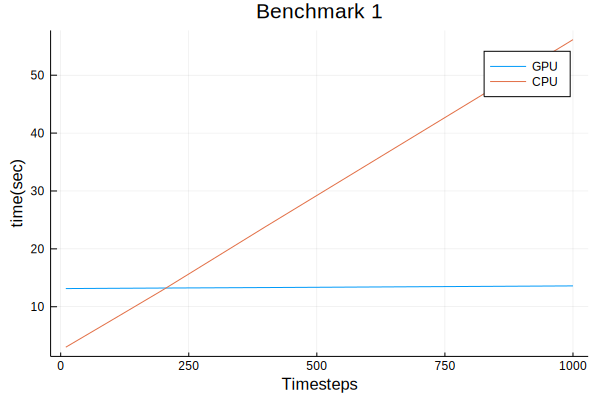

In [16]:
# plot1 4*4*4 voxels, 300 nodes 960 edges
numStep=[10,100,200,400,1000]
firstStepAvg=13.1276
performanceGPU=[0.012447,0.05713079,0.102851299,0.1864829,0.4725757]
performanceCPU=[3.014437901,7.700779099,12.9343908,23.8421247,56.1430382]
plot(numStep,[firstStepAvg.+performanceGPU,performanceCPU],label=["GPU" "CPU"],title="Benchmark 1",xlabel="Timesteps",ylabel="time(sec)")
# png("../../../02_Presentation/GPUBench1.png")

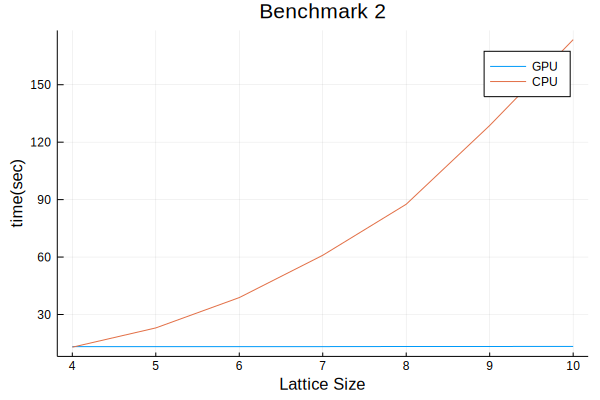

In [15]:
# plot2 200 timesteps
latticeSizes=[4,5,6,7,8,9,10]
performanceGPU=[0.102851299,0.1021396,0.1044742,0.1043413,0.1611617,0.1674361,0.2076308]
performanceCPU=[12.934390801,22.9971574,38.838537,60.9359617,87.5866625,128.7116549,173.5449189]
plot(latticeSizes,[firstStepAvg.+performanceGPU,performanceCPU],label=["GPU" "CPU"],title="Benchmark 2",xlabel="Lattice Size",ylabel="time(sec)")
# png("../../../02_Presentation/GPUBench2.png")

In [17]:
CuDevice(0)

CuDevice(0): GeForce GTX 1070 Ti